# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01    89% |████████████████████████████▋   | 13.0MB 24.5MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

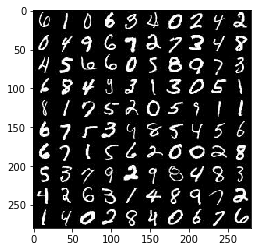

In [2]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

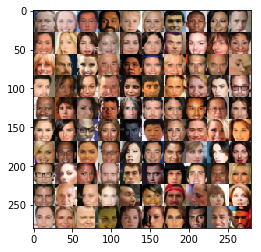

In [3]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    return (tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels)),
            tf.placeholder(dtype=tf.float32, shape=(None, z_dim)),
            tf.placeholder(dtype=tf.float32, shape=(None)))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    ##~~Hyperparameters~~
    learning_rate = 1e-1
    dropout = 0.5
    layer1_outputs = 64
    layer2_outputs = 128
    layer3_outputs = 256
    out_shape = (-1, 7*7*64)
        
    def conv(inputs, num_outputs, kernel_size=5, stride=2, padding='same'):
        return tf.layers.conv2d(inputs, 
                                num_outputs, 
                                kernel_size, 
                                strides=stride,
                                padding=padding,
                                activation=tf.nn.elu)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        ## Layer 1; input: 28x28x3; output:
        conv1 = conv(images, layer1_outputs)
        #conv1 = tf.nn.leaky_relu(conv1, alpha=learning_rate) # leaky_relu not recognized at a function ???
        
        ## Layer 2
        conv2 = conv(conv1, layer2_outputs)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        #conv2 = tf.nn.dropout(conv2, keep_prob=dropout)
        
        ## Layer 3
        conv3 = conv(conv2, layer3_outputs) #tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        #conv3 = tf.nn.dropout(conv3, keep_prob=dropout)
        
        flat = tf.reshape(conv3, (-1,  4 * 4 * layer3_outputs))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        return (output, logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    ##~~Hyperparameters~~
    learning_rate = 1e-1
    dropout = 0.5
    inputs = 7*7*512
    layer1_outputs = 256
    layer2_outputs = 128
    layer3_outputs = 64
    
    shape = 28 * 28 * out_channel_dim
    def conv_transpose(inputs, filters, kernel_size=5, strides=2, padding='same'):
        return tf.layers.conv2d_transpose(inputs, 
                                          filters, 
                                          kernel_size, 
                                          strides=strides,
                                          padding=padding,
                                          activation=tf.nn.elu)
    
    with tf.variable_scope('generator', reuse=not is_train):
        ## Layer 0
        dense1 = tf.layers.dense(z, 7*7*512)
        dense1 = tf.reshape(dense1, (-1, 7, 7, 512))
        dense1 = tf.layers.batch_normalization(dense1, training=is_train)
        dense1 = tf.nn.relu(dense1)
        
        ## Layer 1
        #conv1 = tf.layers.conv2d_transpose(conv1, layer1_outputs, 5, 1, 'SAME')
        conv1 = conv_transpose(dense1, layer1_outputs, strides=1)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        #conv1 = tf.nn.relu(conv1)

        ## Layer 2
        #conv2 = tf.layers.conv2d_transpose(conv2, layer2_outputs, 5, 2, 'SAME', activation=tf.nn.relu)
        conv2 = conv_transpose(conv1, layer2_outputs)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        #conv2 = tf.nn.relu(conv2)
    
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    def loss(logits, labels):
        # Use cross entropy
        return tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    gen = generator(input_z, out_channel_dim)
    dis_real_out, dis_real_logits = discriminator(input_real) # Expected
    dis_not_real_out, dis_not_real_logits = discriminator(gen, reuse=True)
    
    dis_real_loss = loss(dis_real_logits, tf.ones_like(dis_real_out))
    dis_not_real_loss = loss(dis_not_real_logits, tf.zeros_like(dis_not_real_out))
    
    dis_total_loss = dis_real_loss + dis_not_real_loss
    gen_loss = loss(dis_not_real_logits, tf.ones_like(dis_not_real_out))
    return dis_total_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [60]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    def op(loss, var_list, learning_rate=learning_rate, beta1=beta1):
        # Use NAdam
        return tf.contrib.opt.NadamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(loss, 
                                                                   var_list=var_list)
#         return tf.train.AdamOptimizer(learning_rate=learning_rate, 
#                                              beta1=beta1).minimize(loss, 
#                                                                    var_list=var_list)
    trainables = tf.trainable_variables() # Collect tf vars created with trainable=True
    dis_vars = [t for t in trainables if 'discriminator' in t.name] # Collect vars containing 'discriminator'
    gen_vars = [t for t in trainables if 'generator' in t.name] # Collect vars containing 'generator'
    
    # Update graph operations
    ctrl_inputs = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # https://stackoverflow.com/questions/48260394/whats-the-differences-between-tf-graphkeys-trainable-variables-and-tf-graphkeys
    with tf.control_dependencies(ctrl_inputs):
        dis_train = op(d_loss, var_list=dis_vars)
        gen_train = op(g_loss, var_list=gen_vars)
    
    return dis_train, gen_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [62]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # (tensor of real input images, tensor of z data, learning rate)
    in_imgs, z_data, learning_rate_ = model_inputs(data_shape[1], 
                                                   data_shape[2], 
                                                   data_shape[3],
                                                   z_dim) 
    
    # (discriminator loss, generator loss)
    dis_loss, gen_loss = model_loss(in_imgs, 
                                    z_data, 
                                    data_shape[3]) 
    # (discriminator training operation, generator training operation)
    dis_train_op, gen_train_op = model_opt(dis_loss, 
                                           gen_loss, 
                                           learning_rate, 
                                           beta1) 
    cur_batch = 0 # Track the current batch for consisten output
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):               
                batch_images *= 2. # For some reason batch_images data is half what it should be??
                
                # batch_size x z_dim array filled with random float32 in [-1,1]
                batch_ = tf.random_uniform((batch_size, z_dim), minval=-1, maxval=1).eval()
                
                # Use feed_dict accross operations;
                feed_dict = {in_imgs: batch_images, 
                             z_data: batch_, 
                             learning_rate_: learning_rate}
                
                # Run discriminator model
                sess.run(dis_train_op, 
                         feed_dict=feed_dict)
                
                # Run generator model
                sess.run(gen_train_op, 
                         feed_dict=feed_dict)
                
                    
                if cur_batch % 5 == 0:
                    ## Show loss every five batches
                    dis_train_loss = dis_loss.eval(feed_dict)
                    gen_train_loss = gen_loss.eval(feed_dict)
                    print("Epoch {}/{}".format(epoch_i+1, epochs),
                          "Batch {}".format(cur_batch),
                          "Discriminator Loss: {:.4f}".format(dis_train_loss),
                          "Generator Loss: {:.4f}".format(gen_train_loss))
                if cur_batch % 50 == 0:
                    # Show generator output every hundred batches
                    show_generator_output(sess, 20, z_data, data_shape[3], data_image_mode)
                    
                cur_batch += 1 # Update cur_batch 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4 Batch 0 Discriminator Loss: 48.9328 Generator Loss: 0.0000


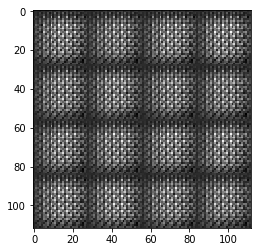

Epoch 1/4 Batch 5 Discriminator Loss: 2.3443 Generator Loss: 0.1578
Epoch 1/4 Batch 10 Discriminator Loss: 10.7213 Generator Loss: 0.0001
Epoch 1/4 Batch 15 Discriminator Loss: 0.5864 Generator Loss: 2.3384
Epoch 1/4 Batch 20 Discriminator Loss: 1.2851 Generator Loss: 2.1246
Epoch 1/4 Batch 25 Discriminator Loss: 0.1392 Generator Loss: 2.7207
Epoch 1/4 Batch 30 Discriminator Loss: 0.3401 Generator Loss: 2.7602
Epoch 1/4 Batch 35 Discriminator Loss: 0.5025 Generator Loss: 2.3296
Epoch 1/4 Batch 40 Discriminator Loss: 0.1574 Generator Loss: 2.7016
Epoch 1/4 Batch 45 Discriminator Loss: 0.7954 Generator Loss: 1.2048
Epoch 1/4 Batch 50 Discriminator Loss: 0.1170 Generator Loss: 2.6400


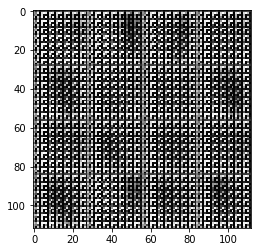

Epoch 1/4 Batch 55 Discriminator Loss: 0.3549 Generator Loss: 1.7958
Epoch 2/4 Batch 60 Discriminator Loss: 0.2668 Generator Loss: 1.9781
Epoch 2/4 Batch 65 Discriminator Loss: 0.0544 Generator Loss: 3.9575
Epoch 2/4 Batch 70 Discriminator Loss: 0.0750 Generator Loss: 3.6446
Epoch 2/4 Batch 75 Discriminator Loss: 0.0068 Generator Loss: 11.5320
Epoch 2/4 Batch 80 Discriminator Loss: 0.1577 Generator Loss: 3.1843
Epoch 2/4 Batch 85 Discriminator Loss: 0.0184 Generator Loss: 5.7839
Epoch 2/4 Batch 90 Discriminator Loss: 0.0714 Generator Loss: 4.4206
Epoch 2/4 Batch 95 Discriminator Loss: 0.1653 Generator Loss: 2.3594
Epoch 2/4 Batch 100 Discriminator Loss: 0.5005 Generator Loss: 8.4415


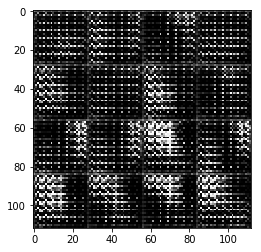

Epoch 2/4 Batch 105 Discriminator Loss: 0.9130 Generator Loss: 9.1643
Epoch 2/4 Batch 110 Discriminator Loss: 0.3259 Generator Loss: 2.3561
Epoch 2/4 Batch 115 Discriminator Loss: 10.7065 Generator Loss: 11.3496
Epoch 3/4 Batch 120 Discriminator Loss: 4.9869 Generator Loss: 6.5266
Epoch 3/4 Batch 125 Discriminator Loss: 2.1692 Generator Loss: 0.2272
Epoch 3/4 Batch 130 Discriminator Loss: 1.1942 Generator Loss: 0.9912
Epoch 3/4 Batch 135 Discriminator Loss: 1.4384 Generator Loss: 0.4367
Epoch 3/4 Batch 140 Discriminator Loss: 2.5548 Generator Loss: 4.6722
Epoch 3/4 Batch 145 Discriminator Loss: 2.7196 Generator Loss: 0.1373
Epoch 3/4 Batch 150 Discriminator Loss: 2.4333 Generator Loss: 2.9614


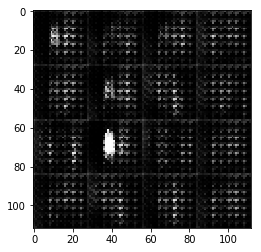

Epoch 3/4 Batch 155 Discriminator Loss: 1.7554 Generator Loss: 0.4875
Epoch 3/4 Batch 160 Discriminator Loss: 2.3114 Generator Loss: 2.5022
Epoch 3/4 Batch 165 Discriminator Loss: 2.1536 Generator Loss: 0.1812
Epoch 3/4 Batch 170 Discriminator Loss: 2.1635 Generator Loss: 3.5125
Epoch 4/4 Batch 175 Discriminator Loss: 2.4136 Generator Loss: 0.1786
Epoch 4/4 Batch 180 Discriminator Loss: 1.7681 Generator Loss: 2.0252
Epoch 4/4 Batch 185 Discriminator Loss: 1.6359 Generator Loss: 0.3984
Epoch 4/4 Batch 190 Discriminator Loss: 1.6240 Generator Loss: 1.9758
Epoch 4/4 Batch 195 Discriminator Loss: 1.8369 Generator Loss: 0.3039
Epoch 4/4 Batch 200 Discriminator Loss: 1.4877 Generator Loss: 1.4390


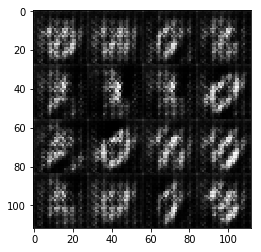

Epoch 4/4 Batch 205 Discriminator Loss: 1.2426 Generator Loss: 0.5535
Epoch 4/4 Batch 210 Discriminator Loss: 1.1886 Generator Loss: 1.5500
Epoch 4/4 Batch 215 Discriminator Loss: 1.6119 Generator Loss: 0.3308
Epoch 4/4 Batch 220 Discriminator Loss: 1.5331 Generator Loss: 1.4454
Epoch 4/4 Batch 225 Discriminator Loss: 1.5799 Generator Loss: 0.4113
Epoch 4/4 Batch 230 Discriminator Loss: 1.5902 Generator Loss: 1.5004


In [63]:
batch_size = 1024 # 2^10
z_dim = 128
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3 Batch 0 Discriminator Loss: 45.1347 Generator Loss: 0.0000


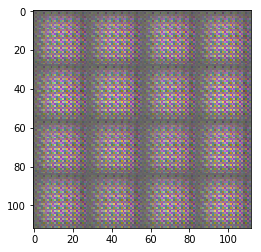

Epoch 1/3 Batch 5 Discriminator Loss: 1.8710 Generator Loss: 0.2486
Epoch 1/3 Batch 10 Discriminator Loss: 0.9442 Generator Loss: 9.6162
Epoch 1/3 Batch 15 Discriminator Loss: 1.9481 Generator Loss: 3.9744
Epoch 1/3 Batch 20 Discriminator Loss: 1.3911 Generator Loss: 1.8921
Epoch 1/3 Batch 25 Discriminator Loss: 2.0815 Generator Loss: 0.8754
Epoch 1/3 Batch 30 Discriminator Loss: 0.8170 Generator Loss: 1.2014
Epoch 1/3 Batch 35 Discriminator Loss: 1.5201 Generator Loss: 4.4013
Epoch 1/3 Batch 40 Discriminator Loss: 1.2265 Generator Loss: 0.7145
Epoch 1/3 Batch 45 Discriminator Loss: 2.5491 Generator Loss: 0.1891
Epoch 1/3 Batch 50 Discriminator Loss: 1.1385 Generator Loss: 2.2301


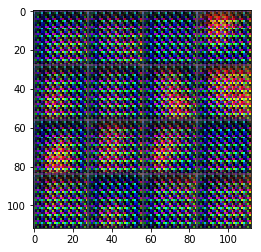

Epoch 1/3 Batch 55 Discriminator Loss: 1.0315 Generator Loss: 0.7764
Epoch 1/3 Batch 60 Discriminator Loss: 1.5854 Generator Loss: 1.3532
Epoch 1/3 Batch 65 Discriminator Loss: 1.3873 Generator Loss: 0.4527
Epoch 1/3 Batch 70 Discriminator Loss: 1.8521 Generator Loss: 1.9321
Epoch 1/3 Batch 75 Discriminator Loss: 2.4569 Generator Loss: 0.9783
Epoch 1/3 Batch 80 Discriminator Loss: 1.8725 Generator Loss: 1.5235
Epoch 1/3 Batch 85 Discriminator Loss: 1.6168 Generator Loss: 0.4224
Epoch 1/3 Batch 90 Discriminator Loss: 1.5372 Generator Loss: 1.0041
Epoch 1/3 Batch 95 Discriminator Loss: 1.5441 Generator Loss: 0.4082
Epoch 1/3 Batch 100 Discriminator Loss: 1.5158 Generator Loss: 1.3047


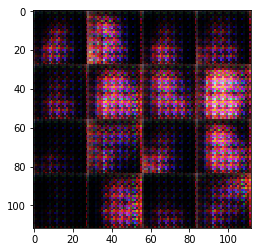

Epoch 1/3 Batch 105 Discriminator Loss: 1.6966 Generator Loss: 1.1048
Epoch 1/3 Batch 110 Discriminator Loss: 1.4499 Generator Loss: 0.5250
Epoch 1/3 Batch 115 Discriminator Loss: 1.4079 Generator Loss: 1.6638
Epoch 1/3 Batch 120 Discriminator Loss: 1.2345 Generator Loss: 0.4875
Epoch 1/3 Batch 125 Discriminator Loss: 1.0875 Generator Loss: 0.8541
Epoch 1/3 Batch 130 Discriminator Loss: 1.3755 Generator Loss: 0.5608
Epoch 1/3 Batch 135 Discriminator Loss: 1.4563 Generator Loss: 2.2189
Epoch 1/3 Batch 140 Discriminator Loss: 1.1532 Generator Loss: 0.5927
Epoch 1/3 Batch 145 Discriminator Loss: 1.3966 Generator Loss: 1.1327
Epoch 1/3 Batch 150 Discriminator Loss: 0.9691 Generator Loss: 1.2578


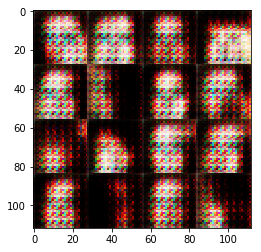

Epoch 1/3 Batch 155 Discriminator Loss: 1.9266 Generator Loss: 0.2463
Epoch 1/3 Batch 160 Discriminator Loss: 1.1800 Generator Loss: 1.3635
Epoch 1/3 Batch 165 Discriminator Loss: 0.8843 Generator Loss: 1.0238
Epoch 1/3 Batch 170 Discriminator Loss: 0.6137 Generator Loss: 1.8795
Epoch 1/3 Batch 175 Discriminator Loss: 0.7236 Generator Loss: 1.0485
Epoch 1/3 Batch 180 Discriminator Loss: 0.6185 Generator Loss: 2.0601
Epoch 1/3 Batch 185 Discriminator Loss: 1.5807 Generator Loss: 0.3158
Epoch 1/3 Batch 190 Discriminator Loss: 1.7058 Generator Loss: 2.3078
Epoch 1/3 Batch 195 Discriminator Loss: 1.4840 Generator Loss: 0.3783
Epoch 2/3 Batch 200 Discriminator Loss: 1.2367 Generator Loss: 0.4489


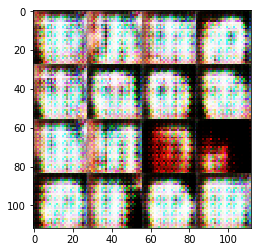

Epoch 2/3 Batch 205 Discriminator Loss: 0.9522 Generator Loss: 1.1710
Epoch 2/3 Batch 210 Discriminator Loss: 1.4761 Generator Loss: 2.7623
Epoch 2/3 Batch 215 Discriminator Loss: 1.5561 Generator Loss: 0.3030
Epoch 2/3 Batch 220 Discriminator Loss: 1.2972 Generator Loss: 1.6778
Epoch 2/3 Batch 225 Discriminator Loss: 1.1042 Generator Loss: 0.8472
Epoch 2/3 Batch 230 Discriminator Loss: 1.1401 Generator Loss: 2.2212
Epoch 2/3 Batch 235 Discriminator Loss: 0.9692 Generator Loss: 0.7918
Epoch 2/3 Batch 240 Discriminator Loss: 0.4212 Generator Loss: 2.5143
Epoch 2/3 Batch 245 Discriminator Loss: 2.6139 Generator Loss: 0.1259
Epoch 2/3 Batch 250 Discriminator Loss: 1.7125 Generator Loss: 2.3688


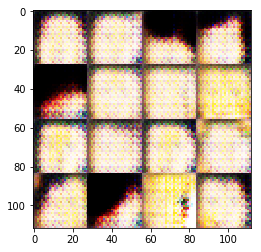

Epoch 2/3 Batch 255 Discriminator Loss: 1.5501 Generator Loss: 0.6949
Epoch 2/3 Batch 260 Discriminator Loss: 1.6211 Generator Loss: 2.4181
Epoch 2/3 Batch 265 Discriminator Loss: 1.6433 Generator Loss: 0.3505
Epoch 2/3 Batch 270 Discriminator Loss: 0.8099 Generator Loss: 1.0674
Epoch 2/3 Batch 275 Discriminator Loss: 1.4348 Generator Loss: 0.7608
Epoch 2/3 Batch 280 Discriminator Loss: 2.0125 Generator Loss: 0.3205
Epoch 2/3 Batch 285 Discriminator Loss: 2.0136 Generator Loss: 0.8511
Epoch 2/3 Batch 290 Discriminator Loss: 1.3552 Generator Loss: 0.7076
Epoch 2/3 Batch 295 Discriminator Loss: 1.5687 Generator Loss: 1.0013
Epoch 2/3 Batch 300 Discriminator Loss: 1.7163 Generator Loss: 1.3875


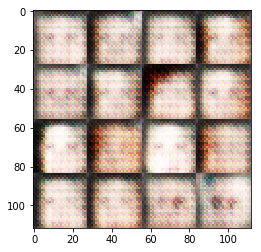

Epoch 2/3 Batch 305 Discriminator Loss: 1.8554 Generator Loss: 0.3810
Epoch 2/3 Batch 310 Discriminator Loss: 1.4394 Generator Loss: 1.6227
Epoch 2/3 Batch 315 Discriminator Loss: 1.5582 Generator Loss: 0.7585
Epoch 2/3 Batch 320 Discriminator Loss: 1.9414 Generator Loss: 0.5504
Epoch 2/3 Batch 325 Discriminator Loss: 1.5210 Generator Loss: 0.7459
Epoch 2/3 Batch 330 Discriminator Loss: 1.5493 Generator Loss: 0.8488
Epoch 2/3 Batch 335 Discriminator Loss: 1.7586 Generator Loss: 0.7125
Epoch 2/3 Batch 340 Discriminator Loss: 1.6806 Generator Loss: 0.6516
Epoch 2/3 Batch 345 Discriminator Loss: 1.4815 Generator Loss: 0.8014
Epoch 2/3 Batch 350 Discriminator Loss: 1.6020 Generator Loss: 0.4801


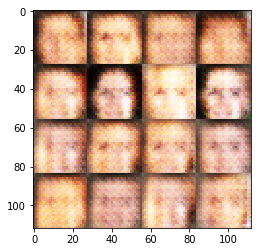

Epoch 2/3 Batch 355 Discriminator Loss: 1.6201 Generator Loss: 0.8294
Epoch 2/3 Batch 360 Discriminator Loss: 1.6715 Generator Loss: 0.9305
Epoch 2/3 Batch 365 Discriminator Loss: 1.5169 Generator Loss: 0.5651
Epoch 2/3 Batch 370 Discriminator Loss: 1.6354 Generator Loss: 0.8027
Epoch 2/3 Batch 375 Discriminator Loss: 1.5869 Generator Loss: 0.5813
Epoch 2/3 Batch 380 Discriminator Loss: 1.5350 Generator Loss: 0.8564
Epoch 2/3 Batch 385 Discriminator Loss: 1.5895 Generator Loss: 0.4652
Epoch 2/3 Batch 390 Discriminator Loss: 1.6548 Generator Loss: 0.7943
Epoch 3/3 Batch 395 Discriminator Loss: 1.4431 Generator Loss: 0.7062
Epoch 3/3 Batch 400 Discriminator Loss: 1.4779 Generator Loss: 0.6976


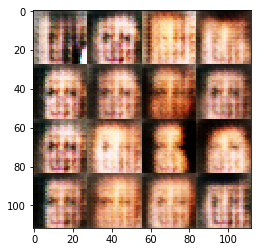

Epoch 3/3 Batch 405 Discriminator Loss: 1.7111 Generator Loss: 0.8208
Epoch 3/3 Batch 410 Discriminator Loss: 1.7200 Generator Loss: 0.6419
Epoch 3/3 Batch 415 Discriminator Loss: 1.5592 Generator Loss: 0.6462
Epoch 3/3 Batch 420 Discriminator Loss: 1.4491 Generator Loss: 0.7667
Epoch 3/3 Batch 425 Discriminator Loss: 1.4621 Generator Loss: 0.6620
Epoch 3/3 Batch 430 Discriminator Loss: 1.4536 Generator Loss: 0.7876
Epoch 3/3 Batch 435 Discriminator Loss: 1.6488 Generator Loss: 0.5927
Epoch 3/3 Batch 440 Discriminator Loss: 1.5720 Generator Loss: 0.7275
Epoch 3/3 Batch 445 Discriminator Loss: 1.5702 Generator Loss: 0.7812
Epoch 3/3 Batch 450 Discriminator Loss: 1.5122 Generator Loss: 0.7726


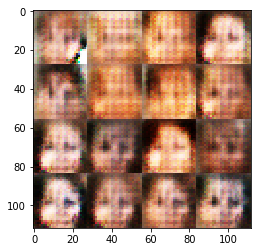

Epoch 3/3 Batch 455 Discriminator Loss: 1.6051 Generator Loss: 0.6899
Epoch 3/3 Batch 460 Discriminator Loss: 1.5058 Generator Loss: 0.7191
Epoch 3/3 Batch 465 Discriminator Loss: 1.4286 Generator Loss: 0.8014
Epoch 3/3 Batch 470 Discriminator Loss: 1.6219 Generator Loss: 0.6469
Epoch 3/3 Batch 475 Discriminator Loss: 1.4851 Generator Loss: 0.7661
Epoch 3/3 Batch 480 Discriminator Loss: 1.5446 Generator Loss: 0.7972
Epoch 3/3 Batch 485 Discriminator Loss: 1.5020 Generator Loss: 0.6749
Epoch 3/3 Batch 490 Discriminator Loss: 1.5156 Generator Loss: 0.6317
Epoch 3/3 Batch 495 Discriminator Loss: 1.4645 Generator Loss: 0.7652
Epoch 3/3 Batch 500 Discriminator Loss: 1.4929 Generator Loss: 0.5845


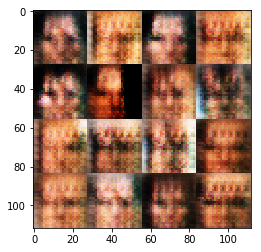

Epoch 3/3 Batch 505 Discriminator Loss: 1.4763 Generator Loss: 0.7237
Epoch 3/3 Batch 510 Discriminator Loss: 1.6132 Generator Loss: 0.6310
Epoch 3/3 Batch 515 Discriminator Loss: 1.4950 Generator Loss: 0.6147
Epoch 3/3 Batch 520 Discriminator Loss: 1.5696 Generator Loss: 0.7429
Epoch 3/3 Batch 525 Discriminator Loss: 1.5084 Generator Loss: 0.6446
Epoch 3/3 Batch 530 Discriminator Loss: 1.4493 Generator Loss: 0.8058
Epoch 3/3 Batch 535 Discriminator Loss: 1.5512 Generator Loss: 0.5832
Epoch 3/3 Batch 540 Discriminator Loss: 1.5500 Generator Loss: 0.8749
Epoch 3/3 Batch 545 Discriminator Loss: 1.5010 Generator Loss: 0.7105
Epoch 3/3 Batch 550 Discriminator Loss: 1.5472 Generator Loss: 0.8305


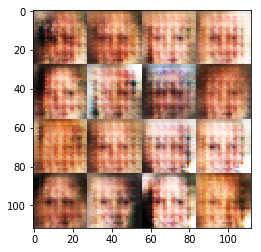

Epoch 3/3 Batch 555 Discriminator Loss: 1.5289 Generator Loss: 0.6954
Epoch 3/3 Batch 560 Discriminator Loss: 1.4538 Generator Loss: 0.7550
Epoch 3/3 Batch 565 Discriminator Loss: 1.4820 Generator Loss: 0.7010
Epoch 3/3 Batch 570 Discriminator Loss: 1.5273 Generator Loss: 0.7602
Epoch 3/3 Batch 575 Discriminator Loss: 1.5183 Generator Loss: 0.7379
Epoch 3/3 Batch 580 Discriminator Loss: 1.6587 Generator Loss: 0.6411
Epoch 3/3 Batch 585 Discriminator Loss: 1.4346 Generator Loss: 0.7529
Epoch 3/3 Batch 590 Discriminator Loss: 1.4477 Generator Loss: 0.6718


In [64]:
batch_size = 1024 # 2^10
z_dim = 128
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.